In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


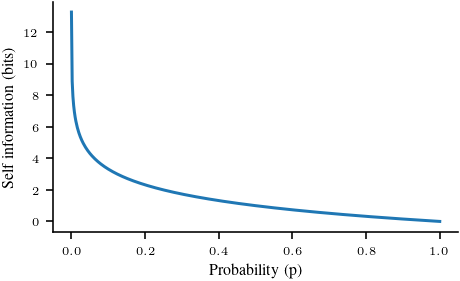

In [4]:
# Self information function
def self_information(p):
    return -np.log2(p)

# Plot self information function from 0 to 1
x = np.linspace(0.0001, 1, 500)
y = self_information(x)
plt.plot(x, y)
plt.xlabel('Probability (p)')
plt.ylabel('Self information (bits)')
plt.savefig('figures/information-theory/self-information.pdf', bbox_inches='tight')

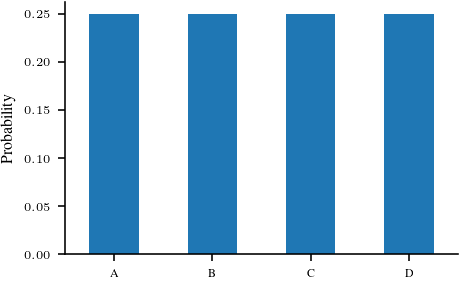

In [5]:
categorical_1 = torch.distributions.Categorical(probs = torch.tensor([0.25, 0.25, 0.25, 0.25]))

ser_1 = pd.Series(index=['A', 'B', 'C', 'D'], data=categorical_1.probs.detach().numpy())
ser_1.plot.bar(rot=0)
plt.ylabel('Probability')
plt.savefig('figures/information-theory/categorical-uniform.pdf', bbox_inches='tight')

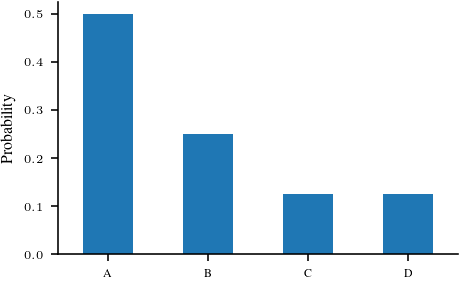

In [6]:
categorical_2 = torch.distributions.Categorical(probs = torch.tensor([0.5, 0.25, 0.125, 0.125]))

ser_2 = pd.Series(index=['A', 'B', 'C', 'D'], data=categorical_2.probs.detach().numpy())
ser_2.plot.bar(rot=0)
plt.ylabel('Probability')
plt.savefig('figures/information-theory/categorical-nonuniform.pdf', bbox_inches='tight')

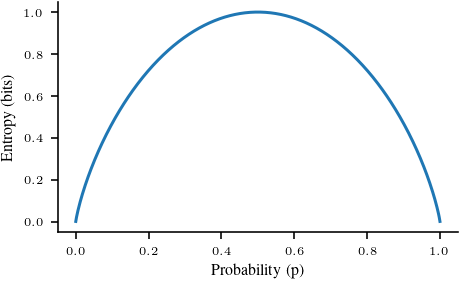

In [7]:
# Entropy for a bernoulli distribution
def entropy_bernoulli(p):
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

# Plot entropy for a bernoulli distribution
x = np.linspace(0.0001, 0.9999, 500)
y = entropy_bernoulli(x)
plt.plot(x, y)
plt.xlabel('Probability (p)')
plt.ylabel('Entropy (bits)')
plt.savefig('figures/information-theory/entropy-bernoulli.pdf', bbox_inches='tight')

2.0


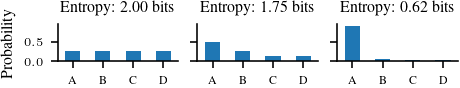

In [8]:
# Figure to take 3 categoriacl distributions on four symbols and title them with their entropy
# Make it two column figure for TUEplots

plt.rcParams.update(bundles.icml2022(nrows=1, ncols=3))


fig, axs = plt.subplots(1, 3, sharey=True)
ser_1.plot.bar(rot=0, ax=axs[0])
axs[0].set_ylabel('Probability')

axs[0].set_title('Entropy: {:.2f} bits'.format(categorical_1.entropy().item()/np.log(2))) # convert loge to log2
# Manually also calculate the entropy
p = categorical_1.probs.detach().numpy()
entropy = -(p * np.log2(p)).sum()
print(entropy)

ser_2.plot.bar(rot=0, ax=axs[1])
axs[1].set_title('Entropy: {:.2f} bits'.format(categorical_2.entropy().item()/np.log(2)))

categorical_3 = torch.distributions.Categorical(probs = torch.tensor([0.9, 0.05, 0.025, 0.025]))
ser_3 = pd.Series(index=['A', 'B', 'C', 'D'], data=categorical_3.probs.detach().numpy())
ser_3.plot.bar(rot=0, ax=axs[2])
axs[2].set_title('Entropy: {:.2f} bits'.format(categorical_3.entropy().item()/np.log(2)))


plt.savefig('figures/information-theory/categorical-entropy.pdf', bbox_inches='tight')


In [11]:
p = {"A": 0.4, "B": 0.3, "C": 0.2, "D": 0.1}
q = {"A": 0.15, "B": 0.55, "C": 0.05, "D": 0.25}

def entropy(p):
    return -(np.array(list(p.values())) * np.log2(np.array(list(p.values())))).sum()

def cross_entropy(p, q):
    return -(np.array(list(p.values())) * np.log2(np.array(list(q.values())))).sum()

def kl_divergence(p, q):
    return cross_entropy(p, q) - entropy(p)

print(entropy(p))
print(cross_entropy(p, q))
print(kl_divergence(p, q))

1.8464393446710154
2.417920799518975
0.5714814548479596


In [10]:
#  Average length of a code

categorical_1.probs


tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [45]:
symbols = ['A', 'B', 'C', 'D']
probs = [0.25, 0.25, 0.25, 0.25]
codes = ['00', '01', '10', '11']

def average_length(probs, codes, symbols):
    # Create a dictionary with the symbols and their probabilities
    symbol_probs = dict(zip(symbols, probs))

    # Create a dictionary with the symbols and their codes
    symbol_codes = dict(zip(symbols, codes))

    symbol_codes_length = {k: len(v) for k, v in symbol_codes.items()}

    # Calculate the average length of a code
    average_length_code = sum([symbol_probs[symbol] * symbol_codes_length[symbol] for symbol in symbols])
    return average_length_code

In [47]:
average_length([0.25, 0.25, 0.25, 0.25], ['00', '01', '10', '11'], ['A', 'B', 'C', 'D'])

2.0

In [48]:
average_length([0.5, 0.25, 0.125, 0.125], ['00', '01', '10', '11'], ['A', 'B', 'C', 'D'])

2.0

In [55]:
import pygraphviz as pgv
from IPython.display import Image
# Heapq imports
import heapq


class Node:
    def __init__(self, symbol, probability):
        self.symbol = symbol
        self.probability = probability
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.probability < other.probability

def huffman_encoding(symbols):
    # Step 1: Calculate probabilities
    probabilities = {}
    total_symbols = len(symbols)
    for symbol in symbols:
        probabilities[symbol] = symbols.count(symbol) / total_symbols

    # Step 2: Create initial nodes
    nodes = [Node(symbol, probability) for symbol, probability in probabilities.items()]

    # Step 3: Sort nodes
    heapq.heapify(nodes)

    # Step 4: Build Huffman tree
    while len(nodes) > 1:
        left = heapq.heappop(nodes)
        right = heapq.heappop(nodes)
        parent = Node(None, left.probability + right.probability)
        parent.left = left
        parent.right = right
        heapq.heappush(nodes, parent)

    root = nodes[0]

    # Step 6: Assign binary codes
    codes = {}
    def assign_codes(node, code):
        if node.symbol:
            codes[node.symbol] = code
        else:
            assign_codes(node.left, code + '0')
            assign_codes(node.right, code + '1')

    assign_codes(root, '')

    # Step 7: Convert dot format to graph
    G = pgv.AGraph(tree_dot)
    G.layout(prog='dot')

    return codes, G

# Example usage
symbols = ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C']
codes, tree_dot = huffman_encoding(symbols)

print("Symbol\tCode")
for symbol, code in codes.items():
    print(f"{symbol}\t{code}")

# Plotting the Huffman tree
tree_dot.draw('huffman_tree.png')


ModuleNotFoundError: No module named 'pygraphviz'

# Closed form solution for prior predictive distribution

![CleanShot 2023-06-05 at 17.47.27@2x.png](<attachment:CleanShot 2023-06-05 at 17.47.27@2x.png>)
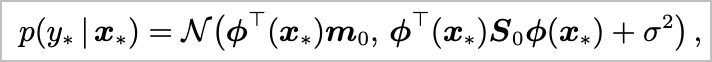

In [ ]:
sigma = 1.0

def prior_predictive(x, sigma, prior_mean, prior_cov):
    """Closed form prior predictive distribution for linear regression."""
    prior_pred_mean = prior_mean[0] + prior_mean[1] * x
    prior_pred_cov = sigma ** 2 + x ** 2 * prior_cov[1, 1]
    return prior_pred_mean, prior_pred_cov